# PART 2 - PV Systems Modeling with Python

Welcome to the tutorial on **PV Systems modeling with Python** at Tec de Monterrey. This tutorial will give an interactive introduction to how to model photovoltaic (PV) system energy yield using the open-source software [pvlib-python](https://pvlib-python.readthedocs.io/).

It is recommended to first complete Part 1 of the tutorial, which gives an introduction to Google Colab and how to retrieve irradiance data using pvlib. Part 1 can be found [here](https://colab.research.google.com/github/PV-Tutorials/2026_pvlib_tec_de_monterrey/blob/main/pvlib-introduction-part-1.ipynb).

We will be modeling the energy yield of a single-axis tracking (SAT) with monofacial modules.

The specific plant is a 232 MW plant in San Luis Potosí, Mexico (see [1]).

![Santiago PV plant](https://www.iberdrola.com/documents/20125/3492972/planta-fotovoltaica-santiago-746x419.jpg/e4ed73ba-de8e-9c97-c9ff-85a92f70b5aa?t=1695119353734)

_Photo credit: Iberdrola [1]._


## Plant specification

The following parameters have been estimated based on freely available data online or estimated:

**General information**
* Location [1]: [Villa de Arriaga, San Luis Potosi, Mexico](https://maps.app.goo.gl/sThBDppisL7GsFfW9)
* Total investment: $200 million
* Start year: 2018
* Estimated output: 460 GWh/year
* Area: 750 hectares

**Plant layout and configuration**
* Mounting: single-axis trackers
* Tracking axis: north-south (0 degrees)
* Module configuration: one-in-portrait (1P)
* Max rotation: 60 degrees (_estimate_)
* Pitch (row-to-row distance): 6 m
* Torque tube height: 1.5 m (_estimate_)

**Modules**
* Total capacity [1]: 232 MW AC
* No. of modules [1]: approx. 672,000
* Module nameplate capacity: ~360 W DC
* Technology [2]: monocrystalline
* Manufacturer [2]: JASolar
* Module model [2]: [JAM72S01-360/PR](https://image.slidesharecdn.com/ja350-370-190415010421/75/JA-370w-72-cell-mono-panel-2-2048.jpg)

## References
- [1] https://www.iberdrola.com/conocenos/nuestra-actividad/energia-solar-fotovoltaica/planta-solar-fotovoltaica-santiago
- [2] https://image.slidesharecdn.com/ja350-370-190415010421/75/JA-370w-72-cell-mono-panel-2-2048.jpg

## Step 1: Install pvlib

First, we need to get pvlib installed in the Colab environment.  Select the code cell below (left click) and execute it (shift+enter) to automatically download and install pvlib:

In [ ]:
!pip install pvlib==0.15.0

In [1]:
# Import libraries
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

## Step 2: Irradiance data
In this step, you need to download irradiance data for the site (see Part 1 of the tutorial for how to do this).

👉 Remember that you need to update the latitude and longitude for the actual PV site.

In [2]:
location = pvlib.location.Location(latitude=21.887, longitude=-101.231)

In [3]:
# retrieve irradiance data
data, meta = pvlib.iotools.get_pvgis_tmy(latitude=21.887, longitude=-101.231)

# shift index
data.index = data.index + pd.Timedelta(minutes=30)

data.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
1990-01-01 00:30:00+00:00,15.39,32.34,0.75,0.0,0.75,274.97,2.78,64.0,77870.0
1990-01-01 01:30:00+00:00,14.89,31.25,0.00,0.0,0.00,269.59,2.56,76.0,77940.0
1990-01-01 02:30:00+00:00,14.38,30.17,0.00,0.0,0.00,264.20,2.33,85.0,77980.0
1990-01-01 03:30:00+00:00,13.88,29.08,0.00,0.0,0.00,258.82,2.11,97.0,78030.0
1990-01-01 04:30:00+00:00,13.37,28.00,0.00,0.0,0.00,253.44,1.88,116.0,78070.0


## Step 3: Calculate solar position
This step was covered in Part 1 of the tutorial. You may copy your code from Part 1 or use the code below.


In [4]:
# Write your code here to calculate solar position
solar_position = location.get_solarposition(data.index)

## Step 4: Calculate tracker orientations

👉 The next step is to determine the orientation (rotation) of the single-axis trackers as this influences the incident irradiance.

The orientation of a single-axis tracker can be calculated using the ``pvlib.tracking.singleaxis`` function ([link to documentation](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.tracking.singleaxis.html)).

You may assume that the tracking axis has the typical orientation of north-south, which corresponds to ``axis_azimuth=0``. Also, we will assume that the SAT features backtracking and has a maximum tracker rotation angle of 60 degrees.

Last, you may notice that the ground coverage ratio (GCR) is also needed but hasn't been provided. This dimensionless ratio can be calculated by dividing the module length (given that it is a 1P configuration) by the pitch (row-to-row distance). You can find the module length in the module datasheet,

In [6]:
max_tracker_angle = 60  # [degrees]
pitch = 6  # [m] center-to-center tracker spacing in the horizontal dimension
module_length = 1.96 # [m] from datasheet
gcr = module_length / pitch

# calculate tracker rotations for a single-axis tracker
tracker_orientations = pvlib.tracking.singleaxis(
    apparent_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    axis_tilt=0,
    axis_azimuth=0,  # corresponds to a north-south tracking axis
    max_angle=max_tracker_angle,
    backtrack=True,
    gcr=gcr,
)


# Print five first non-nan rows
tracker_orientations.dropna().head()

,tracker_theta,aoi,surface_azimuth,surface_tilt
time(UTC),,,,
1990-01-01 13:30:00+00:00,1.796300,87.584834,89.999986,1.796300
1990-01-01 14:30:00+00:00,37.034649,47.349027,90.000000,37.034649
1990-01-01 15:30:00+00:00,59.800220,35.772892,90.000000,59.800220
1990-01-01 16:30:00+00:00,43.175669,40.135576,90.000000,43.175669
1990-01-01 17:30:00+00:00,25.141590,43.266991,89.999999,25.141590


## Step 5: Calculate plane of array irradiance
The irradiance data we obtained from PVGIS contains the three standard components:
- global horizontal irradiance (GHI)
- diffuse horizontal irradiance (DHI)
- direct normal irradiance (DNI)

However, to determine PV generation, we need to know the incident irradiance on the module surface, which is denoted as **plane of array (POA) irradiance**. Since the panels are not bifacial modules, you may ignore the rear side irradiance.

To do this, we will be using pvlib's [infinite sheds bifacial model](https://pvlib-python.readthedocs.io/en/stable/user_guide/bifacial.html#infinite-sheds), which is based on view factors and assumes the PV system comprises of parallel, evenly spaced rows on a level, horizontal surface. The function is called ``pvlib.bifacial.infinite_sheds.get_irradiance`` ([link to documentation](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.bifacial.infinite_sheds.get_irradiance.html)).

You'll notice that the model requires an input called **albedo**. Albedo is a measure of how well the ground reflects irradiance. You may use a value of 0.2, meaning 20% of the irradiance incident on the ground is reflected.

👉 **Can you use the infinite sheds model to calculate front-side irradiance?** Remember, you have determined the tracker orientations in the previous step.

In [9]:
# Write your code here to calculate plane of array irradiance

dni_extra = pvlib.irradiance.get_extra_radiation(data.index)

poa_irradiance = pvlib.bifacial.infinite_sheds.get_irradiance(
    surface_tilt=tracker_orientations['surface_tilt'],
    surface_azimuth=tracker_orientations['surface_azimuth'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    gcr=gcr,
    height=1.5,
    pitch=pitch,
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni'],
    albedo=0.2,
)

# Print five first non-nan rows
poa_irradiance.dropna().head()

,poa_front,poa_front_direct,poa_front_diffuse,poa_front_ground_diffuse,poa_front_sky_diffuse,shaded_fraction_front,poa_back,poa_back_direct,poa_back_diffuse,poa_back_ground_diffuse,poa_back_sky_diffuse,shaded_fraction_back,poa_global
time(UTC),,,,,,,,,,,,,
1990-01-01 13:30:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1990-01-01 14:30:00+00:00,355.704767,302.212508,53.492259,0.660921,52.831338,0.0,12.094046,0.0,12.094046,7.331206,4.762840,0.0,365.186499
1990-01-01 15:30:00+00:00,484.525601,376.096883,108.428717,6.254276,102.174441,0.0,51.177025,0.0,51.177025,21.620541,29.556484,0.0,524.648388
1990-01-01 16:30:00+00:00,450.986776,280.648126,170.338650,5.042048,165.296602,0.0,60.486802,0.0,60.486802,39.256167,21.230635,0.0,498.408428
1990-01-01 17:30:00+00:00,562.735581,359.918756,202.816826,2.458543,200.358283,0.0,71.342707,0.0,71.342707,63.597257,7.745451,0.0,618.668264


## Step 6: Calculate module temperature

The power efficiency of a PV module depends on its temperature (roughly, a 0.4% decrease in power for every increase in °C).  Module temperature can be estimated based on ambient temperature, POA irradiance, and wind speed.

An overview of the temperature models provided in pvlib is available [here](https://pvlib-python.readthedocs.io/en/stable/user_guide/modeling_topics/temperature.html).

👉 Choose a model that estimates cell temperature and calculate the cell temperature based on the weather conditions and the ``poa_front`` irradiance from the previous step.

In [20]:
# Write your code here to calculate module temperature using a model of your choosing
cell_temperature = pvlib.temperature.sapm_cell(
    poa_global=poa_irradiance['poa_front'],
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed'],
    a=-3.56,
    b=-0.075,
    deltaT=3,
)

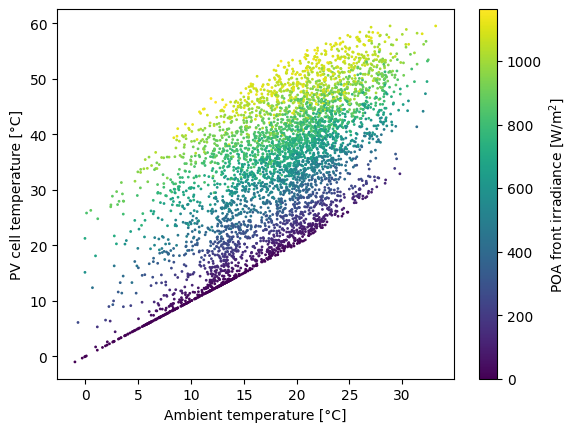

In [21]:
plt.scatter(x=data['temp_air'], y=cell_temperature, s=1, c=poa_irradiance['poa_front'])
plt.xlabel('Ambient temperature [°C]')
plt.ylabel('PV cell temperature [°C]')
plt.colorbar(label='POA front irradiance [W/m$^2$]')
plt.show()

## Step 7: Calculate DC PV power

With the plane of array irradiance and module temperature ready, we can now estimate the PV output power.  There are several modeling approaches available here, including:

* Simple efficiency (like in PVWatts)
* Single-diode models, like in PVsyst and SAM
* Empirical methods like the SAPM

Each type of these PV models requires different types of parameters.  They all produce estimates of the maximum power point (MPP), while the fancier ones also estimate other quantities like open circuit voltage and short circuit current.

👉 The simplest option is to use ``pvlib.pvsystem.pvwatts_dc`` ([link to documentation](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html).  Can you use it with the POA irradiance and module temperature to estimate the output power for one module?

*Note: for this exercise you may assume that the module and cell temperature are the same.*

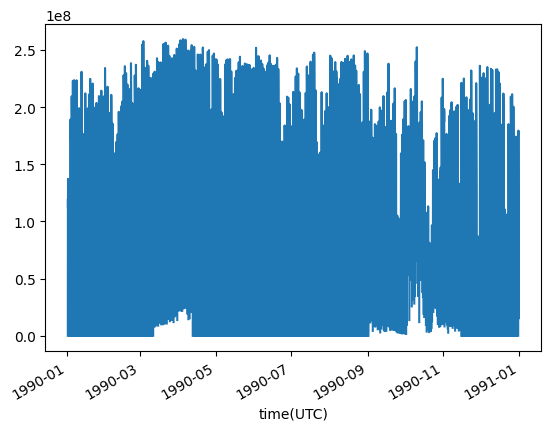

In [24]:
pdc0_module = 360  # [W] Nominal power at STC
no_panels = 672000
pdc0 = pdc0_module * no_panels  # [W] Nominal power at STC for all panels

gamma_pdc = -0.0038 # [1/°C] Pmax temperature coefficient (look at the datasheet, but divide by 100!)

# Write your code here to calculate PV power
dc_power = pvlib.pvsystem.pvwatts_dc(
    effective_irradiance=poa_irradiance['poa_front'],
    temp_cell=cell_temperature,
    pdc0=pdc0,
    gamma_pdc=gamma_pdc,
)

dc_power.plot(); # plot results

## Step 8: Reflect on the exercise

We managed to model the output of one panel, how do you think we can extend the model workflow to simulate a full system?

👉 Last, this exercise made a number of simplifications. Can you name some? How do you think the accuracy was affected?

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).